In [1]:
import numpy as np

start = np.array([-1.0, -3.0])
goal = np.array([-0.5, 2.0])

gates = [
    [0.5, -2.5, 0, 0, 0, -1.57, 0],
    [2.0, -1.5, 0, 0, 0, 0, 0],
    [-0.5, 1.5, 0, 0, 0, 0, 0],
    [0.0, 0.5, 0, 0, 0, 1.57, 0]

]

obstacles = [
    [1.5, -2.5, 0],
    [0.5, -1.0, 0],
    [1.5, 0, 0],
    [-1.0, 0, 0]
]

gates = np.array(gates)

# shuffle gates

obstacles = np.array(obstacles)

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches

# Create a plot

def plot_environment(gates, obstacles, path=None):
    """Visualize the environment with gates and obstacles."""
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot obstacles as filled circles  
    obstacle_diameter = 0.20 # 12 cm = 0.12 m  
    obstacle_radius = obstacle_diameter / 2  
    
    for obs in obstacles:  
        obs_x, obs_y = obs[0], obs[1]  
        circle = patches.Circle(  
            (obs_x, obs_y),  
            obstacle_radius,  
            linewidth=1,  
            edgecolor='magenta',  
            facecolor='magenta'  # Solid fill color  
        )  
        ax.add_patch(circle)  # Plot obstacles as circles  
    
    # Plot gates as filled rectangles  
    gate_width = 0.6  # 40 cm = 0.4 m  
    gate_height = 0.1  # Assuming a height to visualize the gate in 2D  
    
    for idx, gate in enumerate(gates):
        gate_x, gate_y, _, _, _, yaw, _ = gate  
        
        # Create rotation matrix for the gate  
        angle_rad = yaw  
        rotation_matrix = np.array([  
            [np.cos(angle_rad), -np.sin(angle_rad)],  
            [np.sin(angle_rad),  np.cos(angle_rad)]  
        ])  
        
        # Calculate the adjusted center for the gate  
        displacement = np.dot(rotation_matrix, np.array([gate_width / 2, gate_height / 2]))  
        rect_center_x, rect_center_y = gate_x - displacement[0], gate_y - displacement[1]  
        
        rect = patches.Rectangle(  
            (rect_center_x, rect_center_y),  
            gate_width, gate_height,  
            angle=np.degrees(yaw),  
            linewidth=2,  
            edgecolor='b',  
            facecolor='b'  # Solid fill color  
        )  
        ax.add_patch(rect)
        
        # label the gate with its ID
        ax.text(gate_x, gate_y + 0.1, str(idx), fontsize=12, ha='center', va='center', color='white')
        

    # add start and finish points, use stars

    ax.plot(start[0], start[1], 'g*', label='start', markersize=10)
    ax.plot(goal[0], goal[1], 'r*', label='Finish', markersize=10)
    ax.legend(loc='upper right')
    
    # Plot path if provided, with arrows 
    if path is not None:
        path = np.array(path)
        ax.plot(path[:, 0], path[:, 1], 'k-', label='Path', linewidth=2)
        for i in range(len(path) - 1):
            ax.annotate('', xy=path[i + 1], xytext=path[i],
                        arrowprops=dict(arrowstyle='->', color='black', lw=2),
                        fontsize=12, ha='center', va='center')
    
    # Set plot limits  
    ax.set_xlim(-3.5, 3.5)  
    ax.set_ylim(-3.5, 3.5)  
    
    # Set aspect ratio  
    ax.set_aspect('equal', 'box')  
    
    # Labels and title  
    ax.set_xlabel('X Position (m)')  
    ax.set_ylabel('Y Position (m)')  
    ax.set_title('Environment Visualization')

    # Show plot  
    plt.grid(True)  
    plt.show()

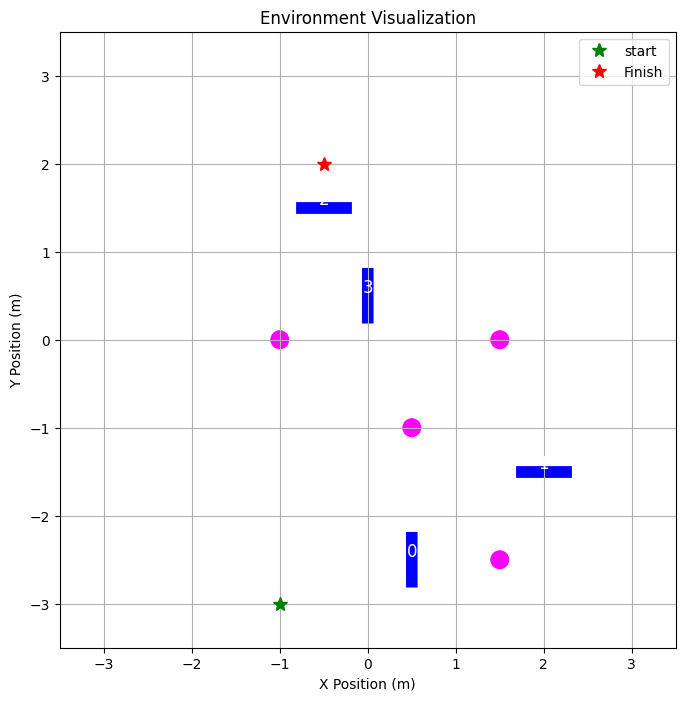

In [3]:
plot_environment(gates, obstacles)

In [4]:
import numpy as np
import heapq


class Node:
    def __init__(self, position, cost, heuristic, parent=None):
        self.position = position
        self.cost = cost
        self.heuristic = heuristic
        self.parent = parent

    def __lt__(self, other):
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)


class AStarPlanner:
    def __init__(self, obstacles, resolution=0.1, obstacle_radius=0.3):
        self.resolution = resolution
        self.obstacle_radius = obstacle_radius
        self.obstacles = obstacles

    def is_collision(self, point):
        for obs in self.obstacles:
            if np.linalg.norm(point - obs[:2]) <= self.obstacle_radius:
                return True
        return False

    def get_neighbors(self, point):
        directions = np.array([
            [1, 0], [-1, 0], [0, 1], [0, -1],
            [1, 1], [1, -1], [-1, 1], [-1, -1]
        ])
        neighbors = []
        for d in directions:
            neighbor = point + self.resolution * d
            if not self.is_collision(neighbor):
                neighbors.append(neighbor)
        return neighbors

    def heuristic(self, a, b):
        return np.linalg.norm(a - b)

    def plan(self, start, goal):
        start = np.round(start / self.resolution) * self.resolution
        goal = np.round(goal / self.resolution) * self.resolution

        open_list = []
        heapq.heappush(open_list, Node(start, 0.0, self.heuristic(start, goal)))
        visited = {}

        while open_list:
            current = heapq.heappop(open_list)
            c_pos = tuple(current.position.round(2))

            if c_pos in visited:
                continue
            visited[c_pos] = current

            if self.heuristic(current.position, goal) <= self.resolution:
                return self.reconstruct_path(current)

            for neighbor in self.get_neighbors(current.position):
                n_pos = tuple(neighbor.round(2))
                if n_pos in visited:
                    continue
                cost = current.cost + np.linalg.norm(neighbor - current.position)
                heuristic = self.heuristic(neighbor, goal)
                heapq.heappush(open_list, Node(neighbor, cost, heuristic, current))

        return None  # No path found

    def reconstruct_path(self, node):
        path = []
        while node:
            path.append(node.position)
            node = node.parent
        return path[::-1]

    def plan_through_waypoints(self, start, waypoints):
        full_path = []
        current_start = start

        for wp in waypoints:
            path_segment = self.plan(current_start, wp[:2])
            if path_segment is None:
                print(f"Failed to reach waypoint {wp[:2]}")
                return None
            if full_path:
                full_path.extend(path_segment[1:])  # skip duplicate
            else:
                full_path.extend(path_segment)
            current_start = wp[:2]

        return np.array(full_path)

In [5]:
def augment_waypoints(gates): 
    """
    Based on yaw angle, add waypoint to front and back of each gate
    """
    
    waypoints = []
    dist = 0.25
    
    for i, gate in enumerate(gates):
        x, y, _, _, _, yaw, _ = gate
        dy = dist * np.cos(yaw)
        dx = dist * np.sin(yaw)
        
        # add waypoint in front of gate
        waypoints.append([x + dx, y + dy, yaw])
        
        # add gate center as waypoint
        waypoints.append([x, y, yaw])
        
        # add waypoint behind gate
        waypoints.append([x - dx, y - dy, yaw])
    
    return np.array(waypoints)

waypoints = augment_waypoints(gates)
print(waypoints)

[[ 0.25000008 -2.49980092 -1.57      ]
 [ 0.5        -2.5        -1.57      ]
 [ 0.74999992 -2.50019908 -1.57      ]
 [ 2.         -1.25        0.        ]
 [ 2.         -1.5         0.        ]
 [ 2.         -1.75        0.        ]
 [-0.5         1.75        0.        ]
 [-0.5         1.5         0.        ]
 [-0.5         1.25        0.        ]
 [ 0.24999992  0.50019908  1.57      ]
 [ 0.          0.5         1.57      ]
 [-0.24999992  0.49980092  1.57      ]]


In [6]:
def augment_obstacles(gates):
    """
    Based on yaw angle, add edges of the gates as obstacles
    """
    
    obs = []
    
    for gate in gates:
        x, y, _, _, _, yaw, _ = gate
        
        # calculate the endpoint of the gate edge
        x1 = x + 0.3 * np.cos(yaw)
        y1 = y + 0.3 * np.sin(yaw)
        x2 = x - 0.3 * np.cos(yaw)
        y2 = y - 0.3 * np.sin(yaw)
        
        # Add points to the obstacle list
        obs.append([x1, y1, 0])
        obs.append([x2, y2, 0])
    return np.array(obs)

obs = augment_obstacles(gates)
obstacles = np.vstack((obstacles, obs))
print(obstacles)

[[ 1.50000000e+00 -2.50000000e+00  0.00000000e+00]
 [ 5.00000000e-01 -1.00000000e+00  0.00000000e+00]
 [ 1.50000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.00238898e-01 -2.79999990e+00  0.00000000e+00]
 [ 4.99761102e-01 -2.20000010e+00  0.00000000e+00]
 [ 2.30000000e+00 -1.50000000e+00  0.00000000e+00]
 [ 1.70000000e+00 -1.50000000e+00  0.00000000e+00]
 [-2.00000000e-01  1.50000000e+00  0.00000000e+00]
 [-8.00000000e-01  1.50000000e+00  0.00000000e+00]
 [ 2.38898013e-04  7.99999905e-01  0.00000000e+00]
 [-2.38898013e-04  2.00000095e-01  0.00000000e+00]]


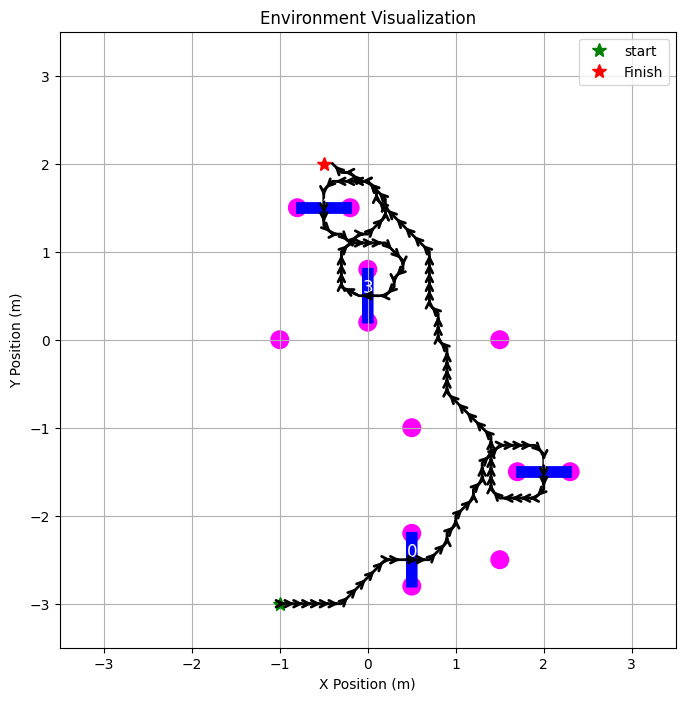

In [7]:
planner = AStarPlanner(obstacles, resolution=0.1, obstacle_radius=0.3)
waypoints = np.vstack((start, waypoints[:, :2], goal))
path = planner.plan_through_waypoints(start, waypoints)

plot_environment(gates, obstacles, path)


In [8]:
from scipy.interpolate import CubicSpline
import numpy as np

def smooth_path_with_cubic_spline(path, num_points=300):
    """
    Smoothens a 3D path using cubic splines with arc-length parameterization.

    Args:
        path (np.ndarray): N x 3 array of waypoints (x, y, z).
        num_points (int): Number of points to interpolate for the smooth path.

    Returns:
        np.ndarray: Smoothed path with shape (num_points, 3)
    """
    if path.shape[0] < 2:
        raise ValueError("Path must have at least 2 points to smooth.")

    # Compute arc-length parameter (cumulative distance)
    distances = np.linalg.norm(np.diff(path, axis=0), axis=1)
    s = np.concatenate(([0], np.cumsum(distances)))

    # Fit separate cubic splines for x(s), y(s), z(s)
    cs_x = CubicSpline(s, path[:, 0])
    cs_y = CubicSpline(s, path[:, 1])
    #cs_z = CubicSpline(s, path[:, 2])

    # Resample along the arc-length
    s_new = np.linspace(0, s[-1], num_points)
    x_new = cs_x(s_new)
    y_new = cs_y(s_new)
    # z_new = cs_z(s_new)

    smoothed_path = np.vstack((x_new, y_new)).T
    return smoothed_path

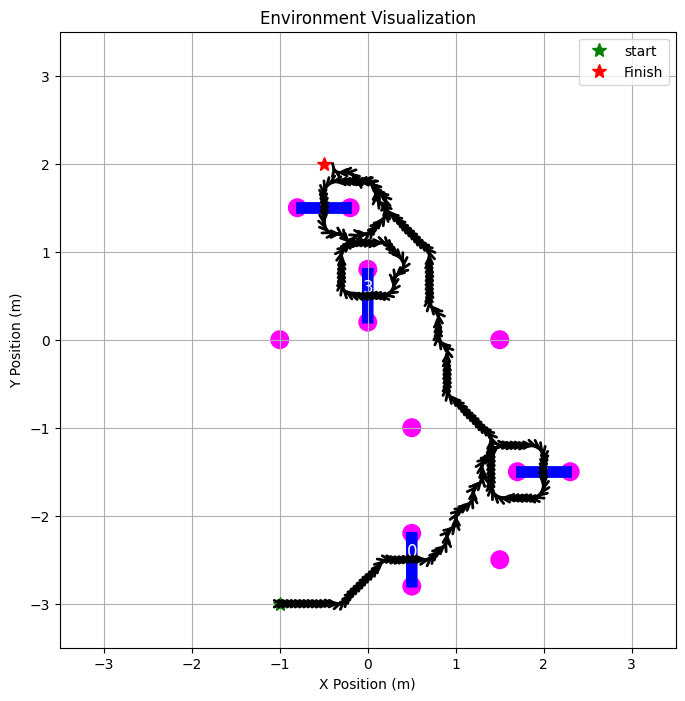

In [9]:
smoothed = smooth_path_with_cubic_spline(path, num_points=300)
plot_environment(gates, obstacles, smoothed)